In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 20, 4
rcParams['figure.dpi'] = 500
rcParams.update({'font.size': 16})

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

# check lib/models.py for network implementation details
from lib.models import RealNVP, dist

In [3]:
hdim = 256
nets = lambda: nn.Sequential(nn.Linear(2, hdim), nn.LeakyReLU(), nn.Linear(hdim, hdim), nn.LeakyReLU(), nn.Linear(hdim, 2), nn.Sigmoid())
"""
nets (net scale)
nets nodes: 2 input nodes, hdim hidden nodes, hdim hidden nodes, 2 output nodes
activations are Relu and last Tanh.
"""
nett = lambda: nn.Sequential(nn.Linear(2, hdim), nn.LeakyReLU(), nn.Linear(hdim, hdim), nn.LeakyReLU(), nn.Linear(256, 2))
"""
nett (net translation)
nett nodes: 2 input nodes, hdim hidden nodes, hdim hidden nodes, 2 output nodes
activations are Relu and no end activation. 
"""
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * 3).astype(np.float32)) #6 coupling layers alternating
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2)) #2D gaussian no correlations
flow = RealNVP(nets, nett, masks, prior)

In [4]:
"""
The model is trained by first 10000 iterations with lr 1e-4 and then 5000 iterations using 1e-5 as learning rate.
"""
optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-4)
for t in range(10001):    
    noisy_moons, label = datasets.make_moons(n_samples=64, noise=.05)
    label = torch.from_numpy(label)
    x = torch.from_numpy(noisy_moons.astype(np.float32))
    loss, z = flow.log_prob(x)
    loss = -loss.mean()
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
        
    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-5)
for t in range(10001, 15001):    
    noisy_moons, label = datasets.make_moons(n_samples=64, noise=.05)
    label = torch.from_numpy(label)
    x = torch.from_numpy(noisy_moons.astype(np.float32))
    loss, z = flow.log_prob(x)
    loss = -loss.mean()
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
        
    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

# Save data in the model to determine the labels during sampling with nearest neighbour.
noisy_moons, label = datasets.make_moons(n_samples=1024, noise=.05)
label = torch.from_numpy(label)
x = torch.from_numpy(noisy_moons.astype(np.float32))
loss, z = flow.log_prob(x)
flow.train_latent_space(z, label)


iter 0: loss = 11.972
iter 500: loss = 0.905
iter 1000: loss = 0.649
iter 1500: loss = 0.595
iter 2000: loss = 0.615
iter 2500: loss = 0.493
iter 3000: loss = 0.422
iter 3500: loss = 0.487
iter 4000: loss = 0.381
iter 4500: loss = 0.463
iter 5000: loss = 0.571
iter 5500: loss = 0.427
iter 6000: loss = 0.587
iter 6500: loss = 0.457
iter 7000: loss = 0.545
iter 7500: loss = 0.951
iter 8000: loss = 0.525
iter 8500: loss = 0.494
iter 9000: loss = 0.463
iter 9500: loss = 0.394
iter 10000: loss = 0.399
iter 10500: loss = 0.411
iter 11000: loss = 0.385
iter 11500: loss = 0.452
iter 12000: loss = 0.365
iter 12500: loss = 0.473
iter 13000: loss = 0.430
iter 13500: loss = 0.489
iter 14000: loss = 0.448
iter 14500: loss = 0.343
iter 15000: loss = 0.451


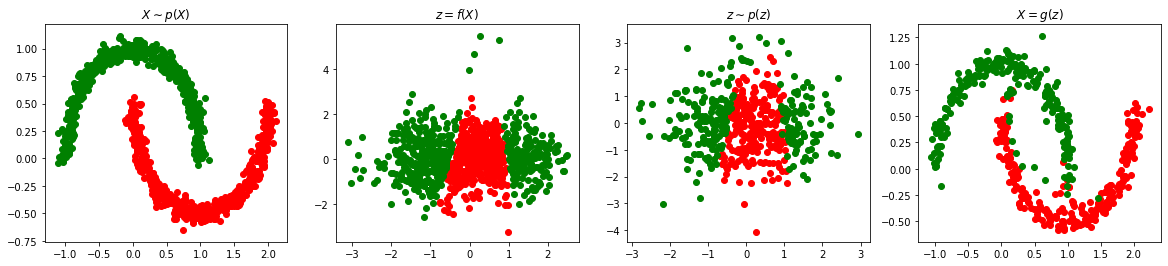

In [5]:
rcParams['figure.figsize'] = 20, 4

# Generate synthetic data for the plots.
noisy_moons, label = datasets.make_moons(n_samples=1000, noise=.05)
u = torch.zeros((1000,2))
l = torch.from_numpy(label)
u[:,0] = l
u[:,1] = 1-l
label = label.astype(bool)

# plot the original data X
plt.subplot(141)
x, y = datasets.make_moons(n_samples=1000, noise=.05)
x = x.astype(np.float32)
y = y.astype(bool)
plt.scatter(x[y, 0], x[y, 1], c='r')
plt.scatter(x[~y, 0], x[~y, 1], c='g')
plt.title(r'$X \sim p(X)$')

# plot the latent space after encoding the data using model.f(x)
z = flow.f(torch.from_numpy(noisy_moons.astype(np.float32)))[0].detach().numpy()
plt.subplot(142)
plt.scatter(z[label, 0], z[label, 1], c='r')
plt.scatter(z[~label, 0], z[~label, 1], c='g')
plt.title(r'$z = f(X)$')

# plot generated latent space points using the prior distribution.
plt.subplot(143)
x0, x1, y0, y1 = flow.sample(500)
x0 = x0.detach().numpy()
x1 = x1.detach().numpy()
y0 = y0.detach().numpy()
y1 = y1.detach().numpy()
plt.scatter(y0[:, 0, 0], y0[:, 0, 1], c='r')
plt.scatter(y1[:, 0, 0], y1[:, 0, 1], c='g')
plt.title(r'$z \sim p(z)$')

# plot the decoded generated latent space points in the orginal space.
plt.subplot(144)
plt.scatter(x0[:, 0, 0], x0[:, 0, 1], c='r')
plt.scatter(x1[:, 0, 0], x1[:, 0, 1], c='g')
plt.title(r'$X = g(z)$')
plt.show()

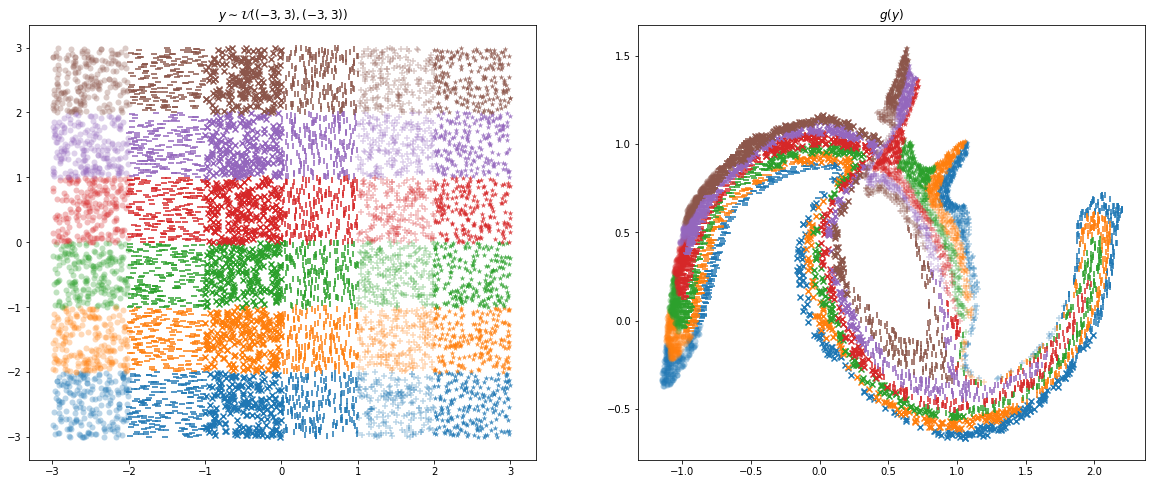

In [6]:
rcParams['figure.figsize'] = 20, 8

# Make a 6x6 grid of the latent space and sample n points unifrom in each quadrant. 
n = 200
xrange = (-3,3)
yrange = (-3,3)
cycle = 6
markers = ['o', '_', 'x', '|', '+', '*']
alphas = [0.3, 1, 1, 1, 0.3, 0.8] 
colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']
block = []
xstep = (xrange[1] - xrange[0]) / cycle
ystep = (yrange[1] - yrange[0]) / cycle
for i in np.linspace(xrange[0], xrange[1]-xstep, cycle):
    for j in np.linspace(yrange[0], yrange[1]-ystep, cycle):
        block.append((torch.FloatTensor(n).uniform_(i, i+xstep),
                      torch.FloatTensor(n).uniform_(j, j+ystep))) 

# plot each quadrant in a seperate color in y direction and separate symbol in x direction in the latent space. 
plt.subplot(121)
plt.title(r'$y \sim \mathcal{U}('+f'{xrange}'+', '+f'{yrange}'+')$')
i = 0
for x, y in block:
    plt.scatter(x, y, linewidths=0, c=colors[i%cycle], marker=markers[i//cycle], alpha=alphas[i//cycle])
    i += 1
    
# plot each quadrant in a seperate color in y direction and seprate symbol in x direction in the original space. 

plt.subplot(122)
plt.title(r'$g(y)$')
i = 0
for x, y in block:
    z = flow.g(torch.stack((x, y)).T).detach().numpy()
    plt.scatter(z[:,0], z[:,1], linewidths=0, c=colors[i%cycle], marker=markers[i//cycle], alpha=alphas[i//cycle])
    i += 1
plt.show()

In [7]:
# Uncomment to save model
# torch.save(flow, "trained_models/Flow_moon.pt")